In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math
import h5py
# import healpy as hp
import pykdgrav3_utils
from pykdgrav3_utils import units
u = units.units(1, 600., verbose=True)

sys.path.append('C:/gaiaenv/New Py/My_thesis/Modules')
from mock_wake import generate_mock_wake
from rotation_funcs import rotate, angle_finder, rz, ry, rx

dMsolUnit = 1.000000e+00
dKpcUnit = 6.000000e+02
dGasConst =  1150890.1952769116
dErgPerGmUnit =  71.68174956254887
dGmPerCcUnit =  3.1333829769061664e-40
dSecUnit =  2.1867420491060357e+23
dKmPerSecUnit =  8.466507518602276e-05
dComovingGmPerCcUnit =  3.1333829769061664e-40


In [2]:
file = 'C:/Data/Praktika_data/dm_sim.00001.0'

def load_snap_file(path, part_type='PartType1', is_print = False):

    snap_file = h5py.File(path, 'r')
    part_data = snap_file[part_type]

    if(is_print):
        print(f'Loading snapshot: {path.split("/")[-1]}')
        print(f'Selected species: {part_type}')
        print(f'Snap file keys: {snap_file.keys()}')
        print(f'Part type keys: {part_data.keys()}')

    return part_data

In [3]:
## Find LMC velocity when it is at 70 kpc distance. Also find its current position.

orbitfile = 'C:/Data/Praktika_data/trajlmc.txt'
orbit_full = pd.read_csv(orbitfile, delimiter = ' ')
orbit = orbit_full.loc[np.where(orbit_full['time'] < 0.01)]
d_orbit = np.sqrt(orbit['x']**2 + orbit['y']**2 + orbit['z']**2)
loc70 = np.isclose(d_orbit, 70.0, 0.01)
# 70 - d_orbit[loc70]
v70 = orbit['Vx'][loc70].values[0], orbit['Vy'][loc70].values[0], orbit['Vz'][loc70].values[0]
LMC_70 = np.array([orbit['x'][loc70].values[0], orbit['y'][loc70].values[0], orbit['z'][loc70].values[0]])

LMC_today = np.isclose(orbit['time'], 0.0, 0.001)
LMC_loc_today = np.array([orbit['x'][LMC_today].values[0], orbit['y'][LMC_today].values[0], orbit['z'][LMC_today].values[0]])


In [4]:
snap_stars = load_snap_file(file, part_type='PartType4', is_print=True)
star_coord = snap_stars['Coordinates'][:]*u.dKpcUnit

Loading snapshot: dm_sim.00001.0
Selected species: PartType4
Snap file keys: <KeysViewHDF5 ['Cosmology', 'Header', 'Parameters', 'PartType1', 'PartType4', 'Units']>
Part type keys: <KeysViewHDF5 ['Coordinates', 'GroupID', 'Masses', 'ParticleIDs', 'Potential', 'Softening', 'StellarFormationTime', 'Velocities']>


In [5]:
## Rotate simulation

z_angle, y_angle = angle_finder(v70)

R = rz(z_angle) @ ry(y_angle)
star_coord_rot = R @ star_coord.T
star_coord_rot = star_coord_rot.T


Rz = -98.38192060960003, Ry = -5.918706233387963


In [6]:
## Find perpendicular and parallel distances

a = (LMC_loc_today - LMC_70)
v_n = v70 / np.linalg.norm(v70)

d_par = np.dot(a, v_n)*v_n
d_perp = a - d_par

In [7]:
LMC_sim_pos = star_coord_rot + LMC_loc_today 
LMC_sim_pos = LMC_sim_pos + d_perp


In [9]:
dist_mask = np.sqrt(LMC_sim_pos[:,0]**2 + LMC_sim_pos[:,1]**2 + LMC_sim_pos[:,2]**2)
masked_LMC = LMC_sim_pos[np.where((dist_mask > 70) & (dist_mask < 100))]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9.99704164e+01, -9.59725429e+01, -9.19746693e+01, -8.79767958e+01,
        -8.39789223e+01, -7.99810488e+01, -7.59831752e+01, -7.19853017e+01,
        -6.79874282e+01, -6.39895546e+01, -5.99916811e+01, -5.59938076e+01,
        -5.19959340e+01, -4.79980605e+01, -4.40001870e+01, -4.00023135e+01,
        -3.60044399e+01, -3.20065664e+01, -2.80086929e+01, -2.40108193e+01,
        -2.00129458e+01, -1.60150723e+01, -1.20171987e+01, -8.01932522e+00,
        -4.02145169e+00, -2.35781602e-02,  3.97429537e+00,  7.97216890e+00,
         1.19700424e+01,  1.59679160e+01,  1.99657895e+01,  2.39636630e+01,
         2.79615365e+01,  3.19594101e+01,  3.59572836e+01,  3.99551571e+01,
         4.39530307e+01,  4.79509042e+01,  5.19487777e+01,  5.59466

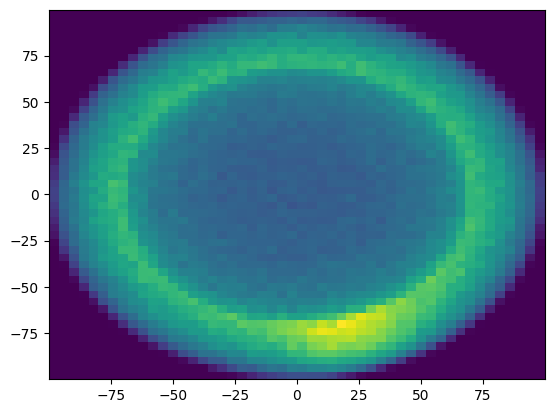

In [12]:
#plt.hist2d(star_coord[:,0][::100], star_coord[:,1][::100], bins=50, cmap='viridis')
# plt.hist2d(LMC_sim_pos[:,0][::100], LMC_sim_pos[:,1][::100], bins=50, cmap='viridis')
plt.hist2d(masked_LMC[:,0][::2], masked_LMC[:,1][::2], bins=50, cmap='viridis')